In [72]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.utils import save_image
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.nn.functional import one_hot

from pytorch_fid import fid_score

In [73]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [74]:
transform = v2.Compose(
    [
     v2.ToTensor(),
     v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = ImageFolder('./trafic_32', transform=transform)
train_classes = train_data.classes
train_classes = [name.lstrip('0') if name != '00000' else '0' for name in train_classes]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [75]:
train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [76]:
data, classes = next(iter(train_loader))
# data.size()
data

tensor([[[[-0.9765, -0.9922, -0.9922,  ..., -0.9765, -0.9843, -0.9922],
          [-0.9765, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.7882, -0.8039, -0.7961,  ..., -0.8118, -0.8196, -0.8196],
          ...,
          [-0.8588, -0.8667, -0.8667,  ..., -0.8902, -0.9059, -0.8902],
          [-0.9686, -0.9765, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9529, -0.9686, -0.9686,  ..., -1.0000, -1.0000, -0.9922]],

         [[-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8275, -0.8196, -0.8118,  ..., -0.8118, -0.8196, -0.8196],
          ...,
          [-0.8588, -0.8510, -0.8510,  ..., -0.8902, -0.8588, -0.8275],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9922]],

         [[-0.9843, -0.9843, -0.9843,  ..., -0.9843, -1.0000, -1.0000],
          [-0.9843, -0.9843, -

## VAE

In [77]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, last_hidden):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_4 = nn.Linear(hidden_dim, last_hidden)

        self.fc_mean  = nn.Linear(last_hidden, latent_dim)
        self.fc_var   = nn.Linear (last_hidden, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))

        x       = self.LeakyReLU(self.fc_4(x))

        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                   # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [78]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, last_hidden):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_4 = nn.Linear(hidden_dim, last_hidden)

        self.fc_5 = nn.Linear(last_hidden, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        h     = self.LeakyReLU(self.fc_4(h))

        x_hat = torch.sigmoid(self.fc_5(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [79]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim, last_hidden):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, last_hidden=last_hidden)
        self.decoder = Decoder(latent_dim=latent_dim + 43, hidden_dim = hidden_dim, output_dim = x_dim, last_hidden=last_hidden)


    def reparameterization(self, mean, var):
        z = torch.rand(1).to(device) * var + mean
        return z


    def forward(self, x, one_hot_class):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        z = torch.concat((z, one_hot_class), dim=1)

        x_hat = self.decoder(z)
        return x_hat, mean, log_var

## Training

In [80]:
vae = VAE(latent_dim=64, hidden_dim=512, x_dim=3072, last_hidden=128).to(device)

In [81]:
encoding = one_hot(torch.arange(0, 43), 43)

In [82]:
def get_classes_encoded(train_classes: list, classes_names: list, encoding):
    return torch.stack([encoding[train_classes.index(str(name.item()))] for name in classes_names], dim=0)

In [83]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [84]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

Epoch 0 loss 375601.0394199346
Epoch 1 loss 345203.0012254902
Epoch 2 loss 335157.18137254904
Epoch 3 loss 325584.14644607843
Epoch 4 loss 322284.0529003268
Epoch 5 loss 320036.6693218954
Epoch 6 loss 318486.3410947712
Epoch 7 loss 316714.66727941175
Epoch 8 loss 314372.80494281044
Epoch 9 loss 312460.79656862747
Epoch 10 loss 310387.7600081699
Epoch 11 loss 309221.34579248365
Epoch 12 loss 308393.57352941175
Epoch 13 loss 306967.4037990196
Epoch 14 loss 306415.42871732026
Epoch 15 loss 305657.36151960783
Epoch 16 loss 305126.42095588235
Epoch 17 loss 305326.81392973854
Epoch 18 loss 304881.6533905229
Epoch 19 loss 304199.64522058825
Epoch 20 loss 303566.1821895425
Epoch 21 loss 303160.3010620915
Epoch 22 loss 303327.26593137253
Epoch 23 loss 302517.7759395425
Epoch 24 loss 302251.7883986928
Epoch 25 loss 302136.6219362745
Epoch 26 loss 301467.5361519608
Epoch 27 loss 301374.87969771243
Epoch 28 loss 301503.6964869281
Epoch 29 loss 300825.50510620914
Epoch 30 loss 300688.54820261436
Ep

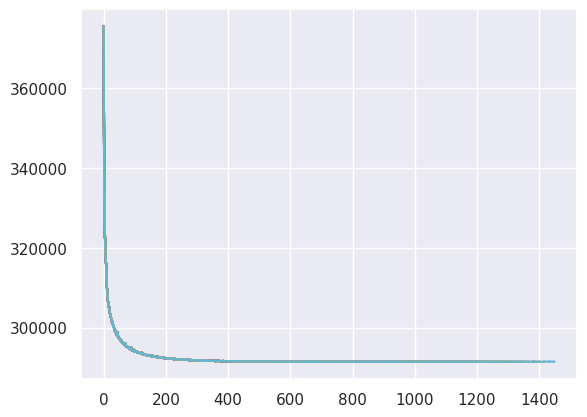

In [85]:
epochs_losses = []
num_epochs = 1500
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)

        classes_encoded = get_classes_encoded(train_classes, _, encoding).to(device)
        out, means, log_var = vae(x, classes_encoded)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epochs_losses.append(np.mean(np.array(losses_epoch)))
    print(f"Epoch {n} loss {epochs_losses[-1]}")
    if n % 50 == 0:
        plt.plot(epochs_losses)

    scheduler.step()

In [86]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(10,10+num)], dim=0)

In [87]:
input_imgs = get_train_images(8)

In [88]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    rmd_to_genrate = torch.randn([n_imgs, model.latent_dim])
    classes_to_generate = torch.concat((rmd_to_genrate, encoding[:n_imgs]), dim=1).to(device)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()


    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

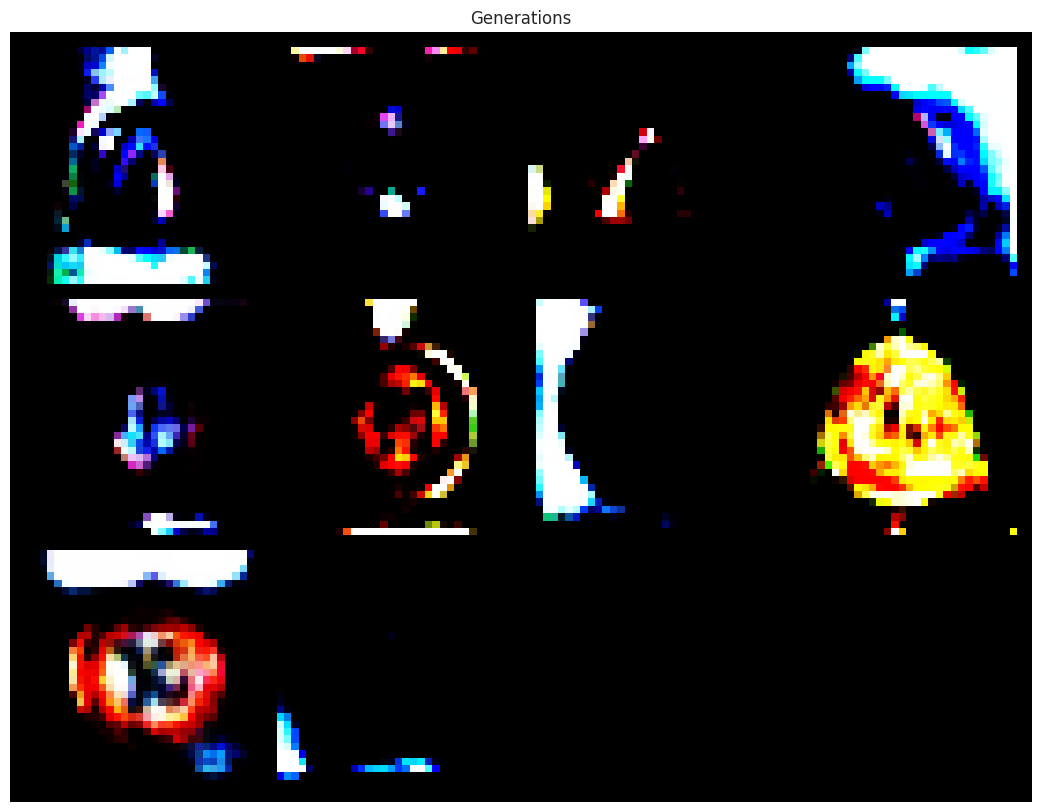

In [53]:
generate_images(vae, 10, device)

In [95]:
def im_save(img, path):
    img = img / 2 + 0.5     # unnormalize
    save_image(img, path)

def evaluate_model(model, train_data, encoding: list, train_classes):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    rmd_to_genrate = torch.randn([10, model.latent_dim])
    encoded_classes = get_classes_encoded(train_classes, labels, encoding)

    classes_to_generate = torch.concat((rmd_to_genrate, encoded_classes), dim=1).to(device)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()
    for i, img in enumerate(generated_imgs):
        im_save(img, f'gen_eval/img{i}.jpg')
    images = images.cpu()
    for i, img in enumerate(images):
        im_save(img, f'real_eval/img{i}.jpg')
    paths = ['real_eval', 'gen_eval']
    return fid_score.calculate_fid_given_paths(paths, batch_size=200, device='cpu', dims=2048)


In [ ]:
evaluate_model(vae, train_data, encoding, train_classes)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
25.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

75.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

